In [15]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ==========================================
# 1. Configuration & Path Setup
# ==========================================

# Define base directory for input data
base_dir = r'C:\Users\bmwlab\Desktop\Testing_Row_Data'

# Define output directory for saving images
output_dir = r'C:\Users\bmwlab\Desktop\Testing_Row_Data\experment\result'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
print(f"Images will be saved to: {output_dir}")

# Define paths for Option 1 and Option 2 to be checked
directories = {
    'Option 1': [
        os.path.join(base_dir, 'option_1', 'merge', 'op1_100_case_1'),
        os.path.join(base_dir, 'option_1', 'merge', 'op1_100_case_2'),
    ],
    'Option 2': [
        os.path.join(base_dir, 'option_2', 'merge', 'op2_100_case_1'),
        os.path.join(base_dir, 'option_2', 'merge', 'op2_100_case_2'),
    ]
}

Images will be saved to: C:\Users\bmwlab\Desktop\Testing_Row_Data\experment\result


In [16]:
# ==========================================
# 2. Analysis Functions
# ==========================================

def check_log_for_success(log_file_path):
    """
    Check if the log file contains 'Received PDU Session Establishment Accept'
    """
    try:
        # Read line by line to save memory
        with open(log_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                if 'Received PDU Session Establishment Accept' in line:
                    return True
            return False
    except Exception as e:
        print(f"Error reading {log_file_path}: {e}")
        return None

def analyze_directory(directory_path):
    """
    Analyze the directory and count error/success cases
    """
    error_count, success_count = 0, 0
    error_files, success_files = [], []
    
    if not os.path.exists(directory_path):
        print(f"Warning: Directory does not exist: {directory_path}")
        return 0, 0, [], []
    
    for filename in sorted(os.listdir(directory_path)):
        if filename.endswith('.json'):
            file_path = os.path.join(directory_path, filename)
            has_success = check_log_for_success(file_path)
            
            if has_success is None: continue
            if not has_success:
                error_count += 1
                error_files.append(filename)
            else:
                success_count += 1
                success_files.append(filename)
    
    return error_count, success_count, error_files, success_files

In [17]:
# ==========================================
# 3. Data Processing
# ==========================================

overall_stats = {}
case_names = []
error_rates = []
colors = []

print(f"\n{'='*30} PROCESSING DATA {'='*30}")

for option_name, dir_list in directories.items():
    print(f"\n--- Analyzing {option_name} ---")
    option_errors, option_success = 0, 0
    
    for directory in dir_list:
        dir_name = os.path.basename(directory)
        e_cnt, s_cnt, e_files, s_files = analyze_directory(directory)
        
        option_errors += e_cnt
        option_success += s_cnt
        total = e_cnt + s_cnt
        
        # Calculate rate for detailed chart
        rate = (e_cnt / total * 100) if total > 0 else 0
        case_names.append(dir_name)
        error_rates.append(rate)
        
        # Assign colors: Blue for Option 1, Orange for Option 2
        colors.append('#3498db' if 'option_1' in directory.lower() else '#e67e22')
        
        print(f"[{dir_name}] Total: {total} | Error: {e_cnt} ({rate:.1f}%)")

    overall_stats[option_name] = {'errors': option_errors, 'success': option_success}


============================== PROCESSING DATA ==============================

--- Analyzing Option 1 ---
[op1_100_case_1] Total: 100 | Error: 30 (30.0%)
[op1_100_case_2] Total: 100 | Error: 25 (25.0%)

--- Analyzing Option 2 ---
[op2_100_case_1] Total: 100 | Error: 73 (73.0%)
[op2_100_case_2] Total: 100 | Error: 61 (61.0%)



[Saved] Detailed plot saved to: C:\Users\bmwlab\Desktop\Testing_Row_Data\experment\result\0_error_rate_by_case.png


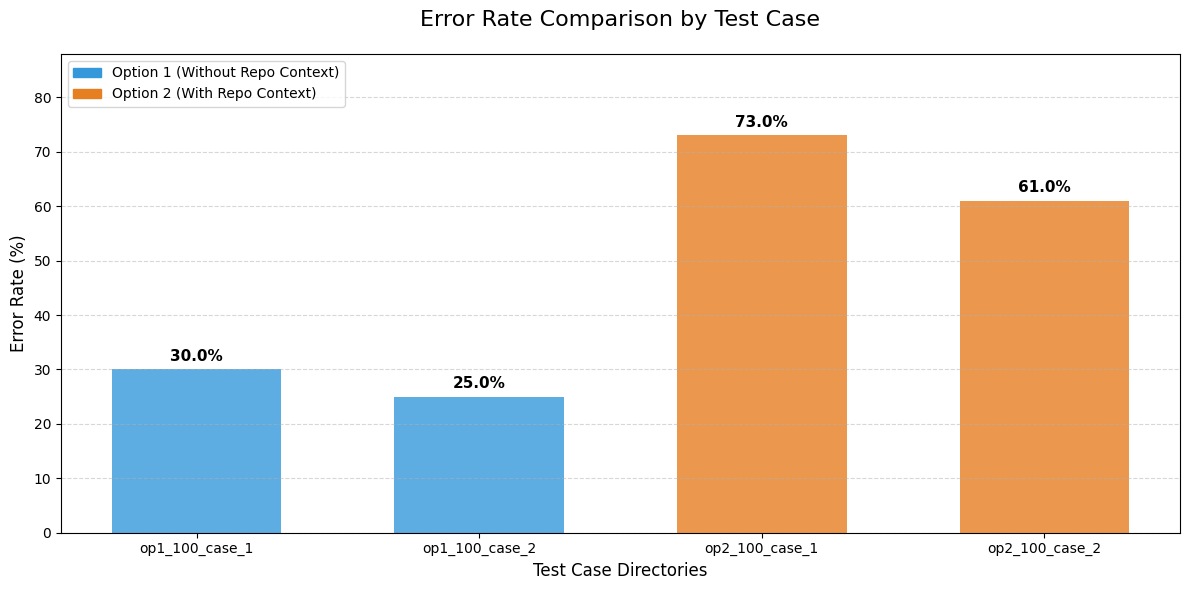


============================== MERGED RESULTS ==============================
[Option 1 Total] Samples: 200 | Error Rate: 27.5%
[Option 2 Total] Samples: 200 | Error Rate: 67.0%
[Saved] Overall plot saved to: C:\Users\bmwlab\Desktop\Testing_Row_Data\experment\result\0_overall_error_rate.png


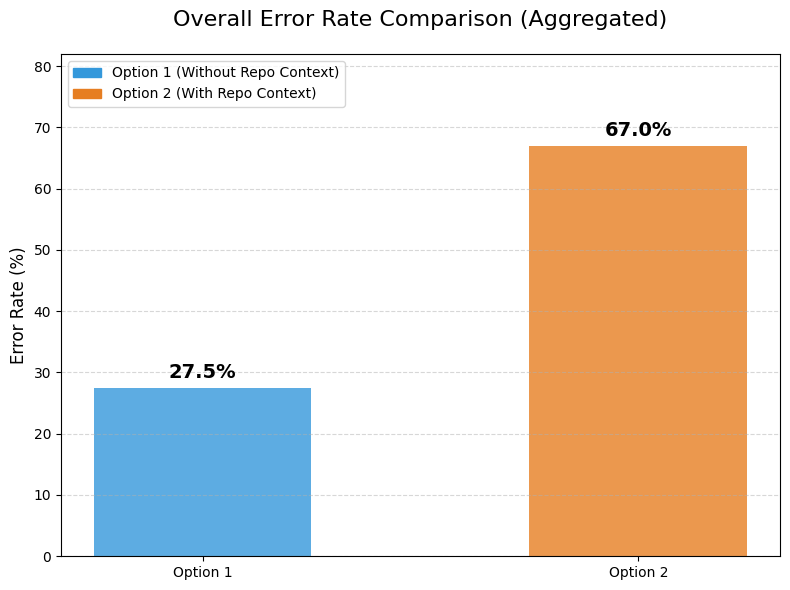

In [18]:
# ==========================================
# 4. Plotting & Saving: Detailed Error Rate
# ==========================================

plt.figure(figsize=(12, 6))
bars = plt.bar(case_names, error_rates, color=colors, alpha=0.8, width=0.6)

# Chart format settings
plt.title('Error Rate Comparison by Test Case', fontsize=16, pad=20)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.xlabel('Test Case Directories', fontsize=12)
plt.ylim(0, max(error_rates) + 15 if error_rates else 100) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate percentages
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Legend
patch1 = mpatches.Patch(color='#3498db', label='Option 1 (Without Repo Context)')
patch2 = mpatches.Patch(color='#e67e22', label='Option 2 (With Repo Context)')
plt.legend(handles=[patch1, patch2], loc='upper left')

plt.tight_layout()

# Save the first plot
save_path_1 = os.path.join(output_dir, '0_error_rate_by_case.png')
plt.savefig(save_path_1)
print(f"\n[Saved] Detailed plot saved to: {save_path_1}")

plt.show()

# ==========================================
# 5. Plotting & Saving: Aggregated Error Rate
# ==========================================

# Prepare merged data
agg_labels = []
agg_rates = []
agg_colors = []

print(f"\n{'='*30} MERGED RESULTS {'='*30}")

for option_name, stats in overall_stats.items():
    total = stats['errors'] + stats['success']
    error_rate = (stats['errors'] / total * 100) if total > 0 else 0
    
    agg_labels.append(option_name)
    agg_rates.append(error_rate)
    
    color = '#3498db' if 'Option 1' in option_name else '#e67e22'
    agg_colors.append(color)
    
    print(f"[{option_name} Total] Samples: {total} | Error Rate: {error_rate:.1f}%")

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(agg_labels, agg_rates, color=agg_colors, alpha=0.8, width=0.5)

# Chart format settings
plt.title('Overall Error Rate Comparison (Aggregated)', fontsize=16, pad=20)
plt.ylabel('Error Rate (%)', fontsize=12)
y_limit = max(agg_rates) + 15 if agg_rates else 100
plt.ylim(0, min(y_limit, 100)) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate percentages
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Legend
plt.legend(handles=[patch1, patch2], loc='upper left')

plt.tight_layout()

# Save the second plot
save_path_2 = os.path.join(output_dir, '0_overall_error_rate.png')
plt.savefig(save_path_2)
print(f"[Saved] Overall plot saved to: {save_path_2}")

plt.show()